### Seasonal San Fransico, CA Air Pollution Analysis: IQR, Box Plot, Outliers

For detailed information on motivation, questions, objectives and exploration of this notebook, visit the Los Angeles or New York notebook.


## Table of Contents
* [Retrieving and Clean Data](#dataclean)
* [Season Sample Measurement Analysis](#beginseason)
    * [Spring](#springdata)
    * [Summer](#summerdata)
    * [Fall](#falldata)
    * [Winter](#winterdata)


----

In [101]:
%matplotlib inline

In [102]:
# Dependencies and Setup
import matplotlib.cbook as cbook
import matplotlib.dates as dates
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np

import json
import copy
from typing import List
import csv


<a id='dataclean'></a>

Import saved csv. CSV includes data generated from 'StateCountySampleDataDF()' function.
Clean data.

In [103]:
# Import from .CSV
ca_la_df = pd.read_csv("./csv_data/california_sanfrancisco.csv") 

In [104]:
# Verify california is in dataframe
assert ca_la_df['state'][0] == 'California'

In [105]:
# Make copy before filtering
california_filtered_df = ca_la_df.copy()
california_filtered_df.head()

,state_code,state,county_code,county,site_number,parameter,sample_measurement,units_of_measure,latitude,longitude,date_local,time_local,date_gmt,time_gmt,method_type,method_code,method,date_of_last_change,cbsa_code
0,6,California,75,San Francisco,5,PM2.5 - Local Conditions,1.0,Micrograms/cubic meter (LC),37.765946,-122.399044,2019-12-01,23:00,2019-12-02,07:00,FEM,170,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,2020-02-25,41860
1,6,California,75,San Francisco,5,PM2.5 - Local Conditions,0.0,Micrograms/cubic meter (LC),37.765946,-122.399044,2019-12-01,22:00,2019-12-02,06:00,FEM,170,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,2020-02-25,41860
2,6,California,75,San Francisco,5,PM2.5 - Local Conditions,1.0,Micrograms/cubic meter (LC),37.765946,-122.399044,2019-12-01,21:00,2019-12-02,05:00,FEM,170,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,2020-02-25,41860
3,6,California,75,San Francisco,5,PM2.5 - Local Conditions,3.0,Micrograms/cubic meter (LC),37.765946,-122.399044,2019-12-01,20:00,2019-12-02,04:00,FEM,170,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,2020-02-25,41860
4,6,California,75,San Francisco,5,PM2.5 - Local Conditions,4.0,Micrograms/cubic meter (LC),37.765946,-122.399044,2019-12-01,19:00,2019-12-02,03:00,FEM,170,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,2020-02-25,41860


### Clean dataset.

In [106]:
# Select certain columns to use for mapping, 
california_filtered_df=california_filtered_df[['county','site_number','sample_measurement','latitude','longitude','time_local','date_gmt','time_gmt','date_of_last_change']]
# Drop nan values and empty values
california_filtered_df=california_filtered_df.dropna()
# Remove all numbers below 0 and above 400
california_filtered_df=california_filtered_df[(california_filtered_df[['sample_measurement']] > 0).all(axis=1) & (california_filtered_df[['sample_measurement']] < 400).all(axis=1)]

In [107]:
ca_filtered_noIndexChange = california_filtered_df

In [108]:
# Assign date_gmt DateTimeIndex. Allows for date searching throug index.
california_filtered_df['date_gmt']=pd.DatetimeIndex(california_filtered_df['date_gmt'])
#Set index to date_gmt
california_filtered_df = california_filtered_df.set_index('date_gmt').sort_values(by=['date_gmt'])


### Clean Copy dataset.

In [109]:
# Copy of clean data
ca_sf_clean_data = california_filtered_df.copy()
ca_sf_clean_data

,county,site_number,sample_measurement,latitude,longitude,time_local,time_gmt,date_of_last_change
date_gmt,,,,,,,,
2019-01-01,San Francisco,5,5.0,37.765946,-122.399044,00:00,08:00,2019-03-13
2019-01-01,San Francisco,5,2.0,37.765946,-122.399044,14:00,22:00,2019-03-13
2019-01-01,San Francisco,5,2.0,37.765946,-122.399044,13:00,21:00,2019-03-13
2019-01-01,San Francisco,5,1.0,37.765946,-122.399044,11:00,19:00,2019-03-13
2019-01-01,San Francisco,5,2.0,37.765946,-122.399044,10:00,18:00,2019-03-13
...,...,...,...,...,...,...,...,...
2019-12-02,San Francisco,5,3.0,37.765946,-122.399044,18:00,02:00,2020-02-25
2019-12-02,San Francisco,5,4.0,37.765946,-122.399044,19:00,03:00,2020-02-25
2019-12-02,San Francisco,5,3.0,37.765946,-122.399044,20:00,04:00,2020-02-25


### Add Column: Add Color to specific sample measurement
Used in scatter plot later.

In [110]:
# Color thresholds
colors_list = []
for row in ca_sf_clean_data['sample_measurement']:
    # if more than a value,
    if row > 55.5:
        # Append color value
        colors_list.append('#e80c0c')
    # else, if more than a value,
    elif row > 35.5:
        # Append color value
        colors_list.append('#e8970c')
    elif row > 12.1:
        # Append color value
        colors_list.append('#dbe36b')
    elif row > 0:
        # Append color value
        colors_list.append('#5cb85c')
    else:
        # Append a failing grade
        colors_list.append('Failed')
        #print(f'failed to apply color on row {row}')
        
# Create a column from the list
ca_sf_clean_data['color'] = colors_list

ca_sf_clean_data['color'].value_counts()

#5cb85c    6414
#dbe36b    1245
#e8970c       6
Name: color, dtype: int64

In [111]:
# Check for Failed values. No Failed values.
assert any(ca_sf_clean_data['color'] == 'Failed') == False

* 37.765946,-122.399044 = San Francisco (5)

In [112]:
ca_sf_clean_data['2019-03-01':'2019-05-31']

,county,site_number,sample_measurement,latitude,longitude,time_local,time_gmt,date_of_last_change,color
date_gmt,,,,,,,,,
2019-03-01,San Francisco,5,6.0,37.765946,-122.399044,05:00,13:00,2019-08-27,#5cb85c
2019-03-01,San Francisco,5,5.0,37.765946,-122.399044,15:00,23:00,2019-08-27,#5cb85c
2019-03-01,San Francisco,5,8.0,37.765946,-122.399044,14:00,22:00,2019-08-27,#5cb85c
2019-03-01,San Francisco,5,10.0,37.765946,-122.399044,13:00,21:00,2019-08-27,#5cb85c
2019-03-01,San Francisco,5,9.0,37.765946,-122.399044,12:00,20:00,2019-08-27,#5cb85c
...,...,...,...,...,...,...,...,...,...
2019-05-31,San Francisco,5,7.0,37.765946,-122.399044,19:00,03:00,2019-09-19,#5cb85c
2019-05-31,San Francisco,5,7.0,37.765946,-122.399044,18:00,02:00,2019-09-19,#5cb85c
2019-05-31,San Francisco,5,5.0,37.765946,-122.399044,17:00,01:00,2019-09-19,#5cb85c


<a id='beginseason'></a>

## Begin Season Sample Measurement Analysis
* Spring, Summer, Fall, Winter
    * Scatter Plot
    * IQR Results
    * Box Plots
    * Outliers

<a id='springdata'></a>

### Season: Spring

In [113]:
# Sort by date_gmt and time_gmt
spring_ca_sf = ca_sf_clean_data['2019-03-01':'2019-05-31']

**Reset index for and set new index for box plot.**

In [114]:
spring_ca_sf_box=spring_ca_sf.reset_index().set_index('site_number').sort_values(by=['site_number','time_gmt'], ascending=True)

In [115]:
ca_sf_clean_data

,county,site_number,sample_measurement,latitude,longitude,time_local,time_gmt,date_of_last_change,color
date_gmt,,,,,,,,,
2019-01-01,San Francisco,5,5.0,37.765946,-122.399044,00:00,08:00,2019-03-13,#5cb85c
2019-01-01,San Francisco,5,2.0,37.765946,-122.399044,14:00,22:00,2019-03-13,#5cb85c
2019-01-01,San Francisco,5,2.0,37.765946,-122.399044,13:00,21:00,2019-03-13,#5cb85c
2019-01-01,San Francisco,5,1.0,37.765946,-122.399044,11:00,19:00,2019-03-13,#5cb85c
2019-01-01,San Francisco,5,2.0,37.765946,-122.399044,10:00,18:00,2019-03-13,#5cb85c
...,...,...,...,...,...,...,...,...,...
2019-12-02,San Francisco,5,3.0,37.765946,-122.399044,18:00,02:00,2020-02-25,#5cb85c
2019-12-02,San Francisco,5,4.0,37.765946,-122.399044,19:00,03:00,2020-02-25,#5cb85c
2019-12-02,San Francisco,5,3.0,37.765946,-122.399044,20:00,04:00,2020-02-25,#5cb85c


### Plot: Spring

Input dataframe name below. Make loop later.

In [116]:
# dataframe to plot
plot_df = spring_ca_sf.copy()
#ax.plot(date, site_number_1103.sample_measurement)
plot_y_information = plot_df.sample_measurement

In [117]:
color_threshold = plot_df.color

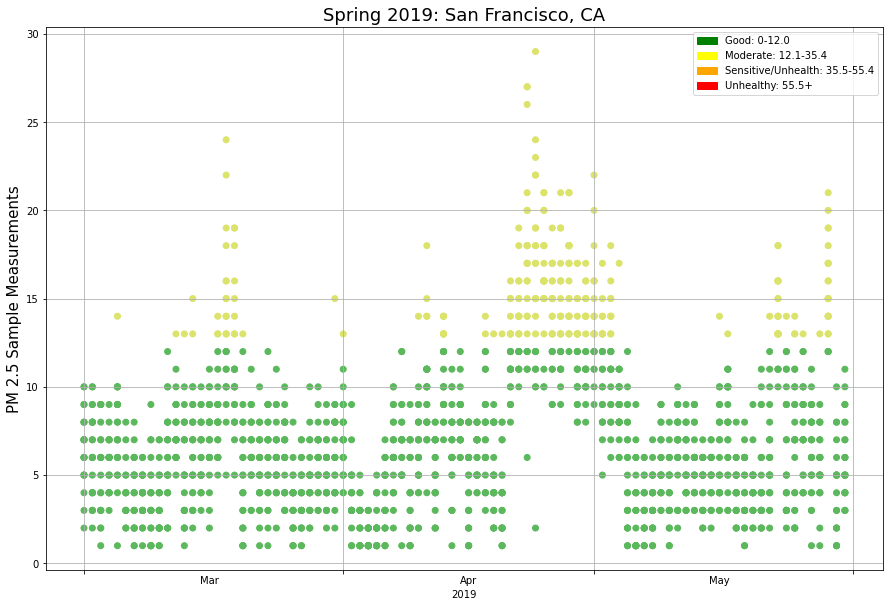

In [118]:
# Assigm date as index of dataframe. Dataframe index has dates
date = plot_df.index.astype('O')

# Data for plt
x = date
y = plot_y_information
c = color_threshold.values


# Plot subplots
fig, ax = plt.subplots(figsize=(15,10))
scatter = ax.scatter(x,y, c=c)

# Set month in xaxis by searching date format
ax.xaxis.set_major_locator(dates.MonthLocator())

# 16 is a slight approximation since months differ in number of days.
ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=16))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%b'))

# loop for custom tickers. Assign marker size and center text
for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment('center')

imid = len(plot_df) // 2
ax.set_xlabel(str(date[imid].year))
ax.set_ylabel('PM 2.5 Sample Measurements', size=15)
ax.set_title('Spring 2019: San Francisco, CA', size=18)
plt.grid(True)

# Labels for legend
green = mpatches.Patch(color='green', label='Good: 0-12.0')
yellow = mpatches.Patch(color='yellow', label='Moderate: 12.1-35.4')
orange = mpatches.Patch(color='orange', label='Sensitive/Unhealth: 35.5-55.4')
red = mpatches.Patch(color='red', label='Unhealthy: 55.5+')
#Call legend
plt.legend(handles = [green,yellow,orange,red])

# Save an image of the chart and print it to the screen
plt.savefig("./Images/SF_spring_pm25_scatter.png")
plt.show()

#### Site Number Seperation: Spring

In [119]:
host_site_num=['5']

In [120]:
# Seperate by site_number
spring_ca_sf['site_number'].unique()
# Identify Site Number: 1103. Filter out values affiliated
spring_site_number_5=spring_ca_sf[(spring_ca_sf[['site_number']]==5).all(axis=1)]


In [121]:
spring_site_number_5=spring_site_number_5[['site_number','sample_measurement','time_gmt']].reset_index().set_index('site_number').sort_values(by=['time_gmt'], ascending=True)


In [122]:
# Make a list of site_numbers. Used in for loops to grab specific data by site number & used for new df header.
filtered_ca_sf_box_list = spring_ca_sf.site_number.sort_values().unique().tolist()

#### Begin IQR for Box Plots

In [123]:
# Look through sample measurement list and count the amount of mice in each drug regimen.
# Create an empty list to fill with for loop
measurement_quartile_spring=[]

# Search through filtered_ca_la_box_data with '.loc[site_number, 'sample_measurement' column]' and get the quartile
for i in filtered_ca_sf_box_list:
    location = spring_ca_sf_box.loc[i, 'sample_measurement'].quantile(q=[.25, .5, .75])
    # append results to measurement_quartile list before moving to next value in tumor_regimen_list
    measurement_quartile_spring.append(location)
measurement_quartile_spring

[0.25    4.0
 0.50    6.0
 0.75    9.0
 Name: sample_measurement, dtype: float64]

In [124]:
iqr_all_spring = []

# loop through measurement_quartile range (0-10). Find IQR by selecting one value at a time in the measurement_quartile list. 
for i in range(len(measurement_quartile_spring)):
    iqr = (measurement_quartile_spring[i][0.75])-(measurement_quartile_spring[i][0.25])
    # Append finding to iqr_all list before moving to next value
    iqr_all_spring.append(iqr)
#print(iqr_all_spring)

# Round numbers to 1 number after decimal.
round_iqr_all_spring = [round(num, 2) for num in iqr_all_spring]

In [125]:
# Show list. Verify we have correct amount
assert len(iqr_all_spring) == 1

In [126]:
# Column/Label list
headers_list=['San Francisco (5)']
# Combine both for loop generated list into one.
measurements_iqr_all_spring = [dict(zip(headers_list, round_iqr_all_spring))]
measurements_iqr_all_spring

[{'San Francisco (5)': 5.0}]

#### Begin Box Plots

In [127]:
# Values for plotting
box_values_spring = round_iqr_all_spring
# Sort to determine outliers
values_sorted_spring = sorted(box_values_spring)
print(values_sorted_spring)

[5.0]


In [128]:
# Sample measurement values per site location
spring_site_5_measurements = spring_site_number_5['sample_measurement']

Number of Samples Measured: 2123


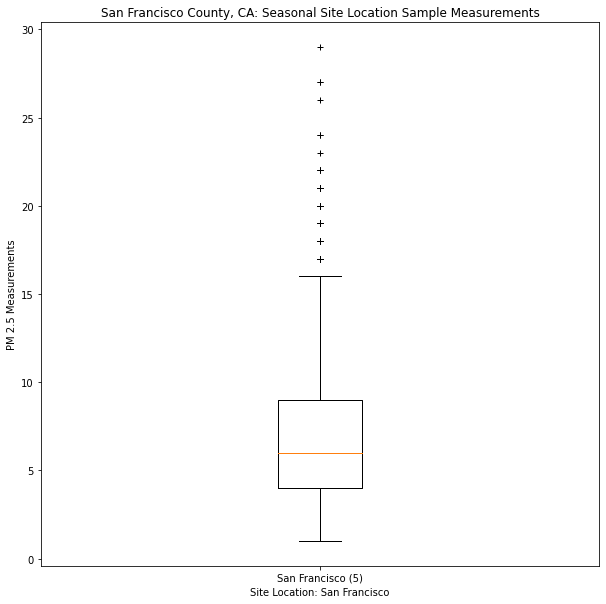

In [129]:
# Generate a box plot of the sample measurement of each site location, annually
measurement_plot_info = [spring_site_5_measurements]
fig, ax = plt.subplots(figsize=(10, 10))
pos = np.array(range(len(measurement_plot_info))) + 1
bp = ax.boxplot(measurement_plot_info, sym='k+', showfliers=True)

ax.set_xticklabels(headers_list)
ax.set_xlabel('Site Location: San Francisco')
ax.set_ylabel('PM 2.5 Measurements')
ax.set_title('San Francisco County, CA: Seasonal Site Location Sample Measurements')


plt.savefig("./Images/SF_spring_pm25_BoxPlot.png")
print(f'Number of Samples Measured: {len(spring_ca_sf)}')
plt.show()

#### Potential Outliers
Filtering by outlier values and dates may tell us which day/month of the year has larger than normal air pollution measurements. 

In [130]:
# San Francisco, CA (16) Outliers
sf_spring_outliers = bp["fliers"][0].get_data()[1]
sf_spring_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(spring_site_5_measurements)}')
print(f'Total amount of outliers: {len(sf_spring_outliers)}')
print(f'San Francisco Outlier values: {sf_spring_outliers}')

Total amount samples in set: 2123
Total amount of outliers: 81
San Francisco Outlier values: [17. 17. 17. 17. 17. 17. 17. 17. 17. 17. 17. 17. 17. 17. 17. 17. 17. 17.
 17. 17. 17. 17. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18.
 18. 18. 18. 18. 18. 18. 18. 18. 18. 19. 19. 19. 19. 19. 19. 19. 19. 19.
 19. 19. 20. 20. 20. 20. 20. 20. 21. 21. 21. 21. 21. 21. 21. 21. 22. 22.
 22. 22. 23. 24. 24. 26. 27. 27. 29.]


<a id='summerdata'></a>

## Season: Summer

In [131]:
# Sort by date_gmt and time_gmt
summer_ca_sf = ca_sf_clean_data['2019-06-01':'2019-08-31'].sort_values(["date_gmt", "time_gmt"])

**Reset index for and set new index for box plot.**

In [132]:
summer_ca_sf_box=summer_ca_sf.reset_index().set_index('site_number').sort_values(by=['site_number','time_gmt'], ascending=True)

### Plot: Summer

Input dataframe name below. Make loop later.

In [133]:
# dataframe to plot
plot_df = summer_ca_sf.copy()
#ax.plot(date, site_number_1103.sample_measurement)
plot_y_information = plot_df.sample_measurement

In [134]:
color_threshold = plot_df.color

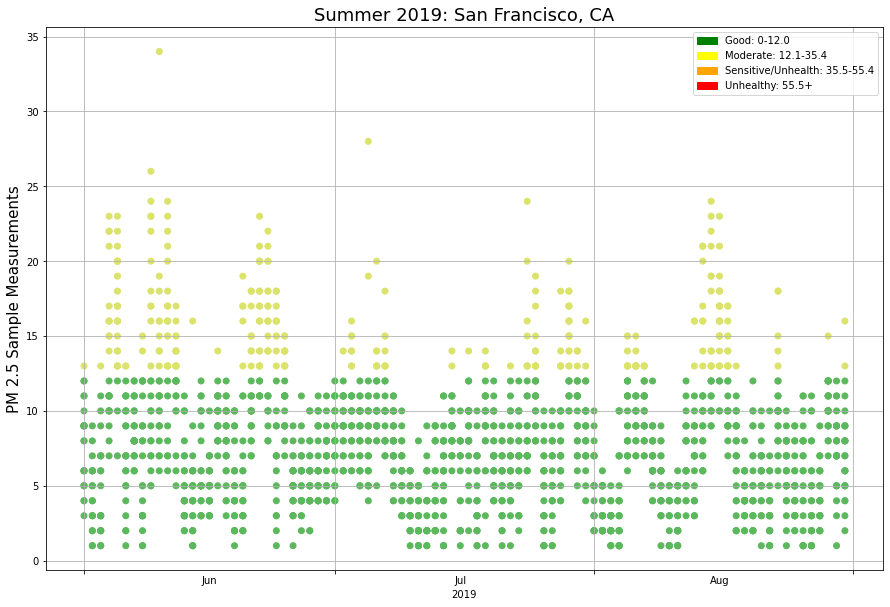

In [135]:
# Assigm date as index of dataframe. Dataframe index has dates
date = plot_df.index.astype('O')

# Data for plt
x = date
y = plot_y_information
c = color_threshold.values


# Plot subplots
fig, ax = plt.subplots(figsize=(15,10))
scatter = ax.scatter(x,y, c=c)

# Set month in xaxis by searching date format
ax.xaxis.set_major_locator(dates.MonthLocator())

# 16 is a slight approximation since months differ in number of days.
ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=16))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%b'))

# loop for custom tickers. Assign marker size and center text
for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment('center')

imid = len(plot_df) // 2
ax.set_xlabel(str(date[imid].year))
ax.set_ylabel('PM 2.5 Sample Measurements', size=15)
ax.set_title('Summer 2019: San Francisco, CA', size=18)
plt.grid(True)

# Labels for legend
green = mpatches.Patch(color='green', label='Good: 0-12.0')
yellow = mpatches.Patch(color='yellow', label='Moderate: 12.1-35.4')
orange = mpatches.Patch(color='orange', label='Sensitive/Unhealth: 35.5-55.4')
red = mpatches.Patch(color='red', label='Unhealthy: 55.5+')
#Call legend
plt.legend(handles = [green,yellow,orange,red])

# Save an image of the chart and print it to the screen
plt.savefig("./Images/SF_summer_pm25_scatter.png")
plt.show()

In [136]:
host_site_num=['5']

In [137]:
# Seperate by site_number
summer_ca_sf['site_number'].unique()
# Identify Site Number: 1103. Filter out values affiliated
summer_site_number_5=summer_ca_sf[(summer_ca_sf[['site_number']]==5).all(axis=1)]


In [138]:
summer_site_number_5=summer_site_number_5[['site_number','sample_measurement','time_gmt']].reset_index().set_index('site_number').sort_values(by=['time_gmt'], ascending=True)


In [139]:
# Make a list of site_numbers. Used in for loops to grab specific data by site number & used for new df header.
filtered_ca_sf_box_list = summer_ca_sf.site_number.sort_values().unique().tolist()
filtered_ca_sf_box_list

[5]

#### Begin IQR for Box Plots

In [140]:
# Look through sample measurement list and count the amount of mice in each drug regimen.
# Create an empty list to fill with for loop
measurement_quartile_summer=[]

# Search through filtered_ca_la_box_data with '.loc[site_number, 'sample_measurement' column]' and get the quartile
for i in filtered_ca_sf_box_list:
    location = summer_ca_sf_box.loc[i, 'sample_measurement'].quantile(q=[.25, .5, .75])
    # append results to measurement_quartile list before moving to next value in tumor_regimen_list
    measurement_quartile_summer.append(location)
measurement_quartile_summer

[0.25     5.0
 0.50     8.0
 0.75    10.0
 Name: sample_measurement, dtype: float64]

In [141]:
iqr_all_summer = []

# loop through measurement_quartile range (0-10). Find IQR by selecting one value at a time in the measurement_quartile list. 
for i in range(len(measurement_quartile_summer)):
    iqr = (measurement_quartile_summer[i][0.75])-(measurement_quartile_summer[i][0.25])
    # Append finding to iqr_all list before moving to next value
    iqr_all_summer.append(iqr)
#print(iqr_all_summer)

# Round numbers to 1 number after decimal.
round_iqr_all_summer = [round(num, 2) for num in iqr_all_summer]

In [142]:
# Show list. Verify we have correct amount
assert len(iqr_all_summer) == 1

In [143]:

# Combine both for loop generated list into one.
measurements_iqr_all_summer = [dict(zip(headers_list, round_iqr_all_summer))]
measurements_iqr_all_summer

[{'San Francisco (5)': 5.0}]

#### Begin Box Plots

In [144]:
# Values for plotting
box_values_summer = round_iqr_all_summer
# Sort to determine outliers
values_sorted_summer = sorted(box_values_summer)
print(values_sorted_summer)

[5.0]


In [145]:
# Sample measurement values per site location
summer_site_5_measurements = summer_site_number_5['sample_measurement']


Number of Samples Measured: 2125


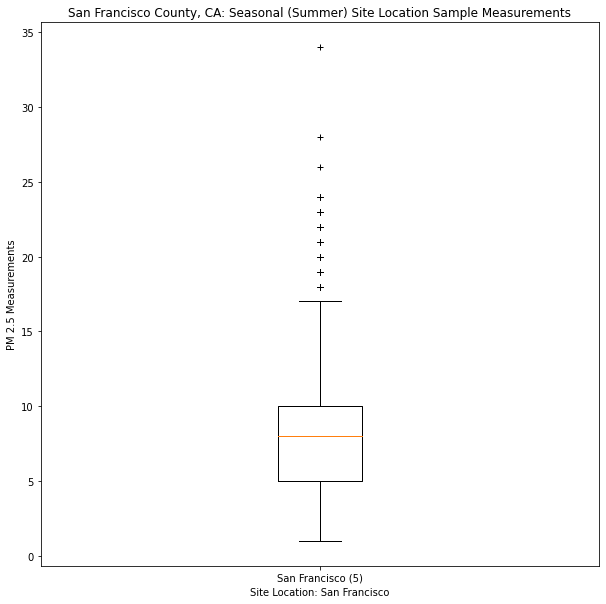

In [146]:
# Generate a box plot of the sample measurement of each site location, annually
measurement_plot_info = [summer_site_5_measurements]

fig, ax = plt.subplots(figsize=(10, 10))
pos = np.array(range(len(measurement_plot_info))) + 1
bp = ax.boxplot(measurement_plot_info, sym='k+', showfliers=True)

ax.set_xticklabels(headers_list)
ax.set_xlabel('Site Location: San Francisco')
ax.set_ylabel('PM 2.5 Measurements')
ax.set_title('San Francisco County, CA: Seasonal (Summer) Site Location Sample Measurements')

plt.savefig("./Images/SF_summer_pm25_BoxPlot.png")
print(f'Number of Samples Measured: {len(summer_ca_sf)}')
plt.show()

#### Potential Outliers
Filtering by outlier values and dates may tell us which day/month of the year has larger than normal air pollution measurements. 

In [147]:
# San Francisco, CA (16) Outliers
sf_summer_outliers = bp["fliers"][0].get_data()[1]
sf_summer_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(summer_site_5_measurements)}')
print(f'Total amount of outliers: {len(sf_summer_outliers)}')
print(f'San Francisco Outlier values: {sf_summer_outliers}')

Total amount samples in set: 2125
Total amount of outliers: 76
San Francisco Outlier values: [18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18.
 18. 18. 18. 18. 18. 19. 19. 19. 19. 19. 19. 19. 19. 20. 20. 20. 20. 20.
 20. 20. 20. 20. 20. 20. 20. 20. 20. 21. 21. 21. 21. 21. 21. 21. 21. 21.
 22. 22. 22. 22. 22. 22. 22. 23. 23. 23. 23. 23. 23. 23. 23. 24. 24. 24.
 24. 26. 28. 34.]


<a id='falldata'></a>

## Season: Fall

In [148]:
# Sort by date_gmt and time_gmt
fall_ca_sf = ca_sf_clean_data['2019-09-01':'2019-11-30'].sort_values(["date_gmt", "time_gmt"])

**Reset index for and set new index for box plot.**

In [149]:
fall_ca_sf_box=fall_ca_sf.reset_index().set_index('site_number').sort_values(by=['site_number','time_gmt'], ascending=True)

### Plot: Fall

Input dataframe name below. Make loop later.

In [150]:
# dataframe to plot
plot_df = fall_ca_sf.copy()
#ax.plot(date, site_number_1103.sample_measurement)
plot_y_information = plot_df.sample_measurement

In [151]:
color_threshold = plot_df.color

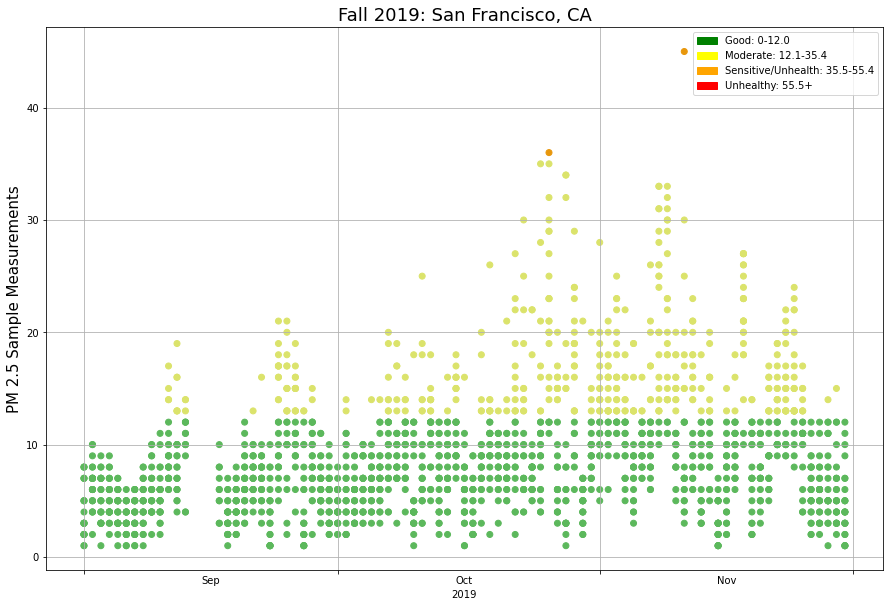

In [152]:
# Assigm date as index of dataframe. Dataframe index has dates
date = plot_df.index.astype('O')

# Data for plt
x = date
y = plot_y_information
c = color_threshold.values


# Plot subplots
fig, ax = plt.subplots(figsize=(15,10))
scatter = ax.scatter(x,y, c=c)

# Set month in xaxis by searching date format
ax.xaxis.set_major_locator(dates.MonthLocator())

# 16 is a slight approximation since months differ in number of days.
ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=16))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%b'))

# loop for custom tickers. Assign marker size and center text
for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment('center')

imid = len(plot_df) // 2
ax.set_xlabel(str(date[imid].year))
ax.set_ylabel('PM 2.5 Sample Measurements', size=15)
ax.set_title('Fall 2019: San Francisco, CA', size=18)
plt.grid(True)

# Labels for legend
green = mpatches.Patch(color='green', label='Good: 0-12.0')
yellow = mpatches.Patch(color='yellow', label='Moderate: 12.1-35.4')
orange = mpatches.Patch(color='orange', label='Sensitive/Unhealth: 35.5-55.4')
red = mpatches.Patch(color='red', label='Unhealthy: 55.5+')
#Call legend
plt.legend(handles = [green,yellow,orange,red])

# Save an image of the chart and print it to the screen
plt.savefig("./Images/SF_fall_pm25_scatter.png")
plt.show()

#### Site Number Seperation: Fall

In [153]:
# Seperate by site_number
fall_ca_sf['site_number'].unique()
# Identify Site Number: 1103. Filter out values affiliated
fall_site_number_5=fall_ca_sf[(fall_ca_sf[['site_number']]==5).all(axis=1)]


In [154]:
fall_site_number_5=fall_site_number_5[['site_number','sample_measurement','time_gmt']].reset_index().set_index('site_number').sort_values(by=['time_gmt'], ascending=True)


In [155]:
# Make a list of site_numbers. Used in for loops to grab specific data by site number & used for new df header.
filtered_ca_sf_box_list = fall_ca_sf.site_number.sort_values().unique().tolist()
filtered_ca_sf_box_list

[5]

#### Begin IQR for Box Plots

In [156]:
# Look through sample measurement list and count the amount of mice in each drug regimen.
# Create an empty list to fill with for loop
measurement_quartile_fall=[]

# Search through filtered_ca_la_box_data with '.loc[site_number, 'sample_measurement' column]' and get the quartile
for i in filtered_ca_sf_box_list:
    location = fall_ca_sf_box.loc[i, 'sample_measurement'].quantile(q=[.25, .5, .75])
    # append results to measurement_quartile list before moving to next value in tumor_regimen_list
    measurement_quartile_fall.append(location)
measurement_quartile_fall

[0.25     5.0
 0.50     8.0
 0.75    12.0
 Name: sample_measurement, dtype: float64]

In [157]:
iqr_all_fall = []

# loop through measurement_quartile range (0-10). Find IQR by selecting one value at a time in the measurement_quartile list. 
for i in range(len(measurement_quartile_fall)):
    iqr = (measurement_quartile_fall[i][0.75])-(measurement_quartile_fall[i][0.25])
    # Append finding to iqr_all list before moving to next value
    iqr_all_fall.append(iqr)
#print(iqr_all_spring)

# Round numbers to 1 number after decimal.
round_iqr_all_fall = [round(num, 2) for num in iqr_all_fall]

In [158]:
# Show list. Verify we have correct amount
assert len(iqr_all_fall) >= 1

In [159]:
# Combine both for loop generated list into one.
measurements_iqr_all_fall = [dict(zip(headers_list, round_iqr_all_fall))]
measurements_iqr_all_fall

[{'San Francisco (5)': 7.0}]

#### Begin Box Plots

In [160]:
# Values for plotting
box_values_fall = round_iqr_all_fall
# Sort to determine outliers
values_sorted_fall = sorted(box_values_fall)
print(values_sorted_fall)

[7.0]


In [161]:
# Sample measurement values per site location
fall_site_5_measurements = fall_site_number_5['sample_measurement']


Number of Samples Measured: 2053


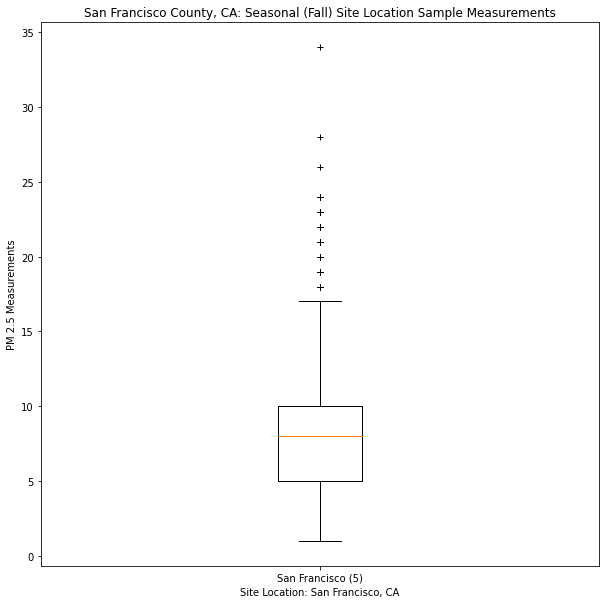

In [162]:
# Generate a box plot of the sample measurement of each site location, annually

fig, ax = plt.subplots(figsize=(10, 10))
pos = np.array(range(len(measurement_plot_info))) + 1
bp = ax.boxplot(measurement_plot_info, sym='k+', showfliers=True)

ax.set_xticklabels(headers_list)
ax.set_xlabel('Site Location: San Francisco, CA')
ax.set_ylabel('PM 2.5 Measurements')
ax.set_title('San Francisco County, CA: Seasonal (Fall) Site Location Sample Measurements')

plt.savefig("./Images/SF_fall_pm25_BoxPlot.png")
print(f'Number of Samples Measured: {len(fall_ca_sf)}')
plt.show()

#### Potential Outliers
Filtering by outlier values and dates may tell us which day/month of the year has larger than normal air pollution measurements. 

In [163]:
# San Francisco, CA (16) Outliers
sf_fall_outliers = bp["fliers"][0].get_data()[1]
sf_fall_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(fall_site_5_measurements)}')
print(f'Total amount of outliers: {len(sf_fall_outliers)}')
print(f'San Francisco Outlier values: {sf_fall_outliers}')

Total amount samples in set: 2053
Total amount of outliers: 76
San Francisco Outlier values: [18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18.
 18. 18. 18. 18. 18. 19. 19. 19. 19. 19. 19. 19. 19. 20. 20. 20. 20. 20.
 20. 20. 20. 20. 20. 20. 20. 20. 20. 21. 21. 21. 21. 21. 21. 21. 21. 21.
 22. 22. 22. 22. 22. 22. 22. 23. 23. 23. 23. 23. 23. 23. 23. 24. 24. 24.
 24. 26. 28. 34.]


<a id='winterdata'></a>

## Season: Winter

In [164]:
# Beginning of the year Winter
# Sort by date_gmt and time_gmt
winter_ca_sf = ca_sf_clean_data['2019-01-01':'2019-02'].sort_values(["date_gmt", "time_gmt"])
winter_ca_sf

,county,site_number,sample_measurement,latitude,longitude,time_local,time_gmt,date_of_last_change,color
date_gmt,,,,,,,,,
2019-01-01,San Francisco,5,5.0,37.765946,-122.399044,00:00,08:00,2019-03-13,#5cb85c
2019-01-01,San Francisco,5,2.0,37.765946,-122.399044,01:00,09:00,2019-03-13,#5cb85c
2019-01-01,San Francisco,5,2.0,37.765946,-122.399044,02:00,10:00,2019-03-13,#5cb85c
2019-01-01,San Francisco,5,4.0,37.765946,-122.399044,03:00,11:00,2019-03-13,#5cb85c
2019-01-01,San Francisco,5,2.0,37.765946,-122.399044,04:00,12:00,2019-03-13,#5cb85c
...,...,...,...,...,...,...,...,...,...
2019-02-28,San Francisco,5,6.0,37.765946,-122.399044,11:00,19:00,2019-05-01,#5cb85c
2019-02-28,San Francisco,5,4.0,37.765946,-122.399044,12:00,20:00,2019-05-01,#5cb85c
2019-02-28,San Francisco,5,2.0,37.765946,-122.399044,13:00,21:00,2019-05-01,#5cb85c


**Reset index for and set new index for box plot.**

In [165]:
winter_ca_sf_box=winter_ca_sf.reset_index().set_index('site_number').sort_values(by=['site_number','time_gmt'], ascending=True)

### Plot: Winter

Input dataframe name below. Make loop later.

In [166]:
# dataframe to plot
plot_df = winter_ca_sf.copy()
#ax.plot(date, site_number_1103.sample_measurement)
plot_y_information = plot_df.sample_measurement

In [167]:
color_threshold = plot_df.color

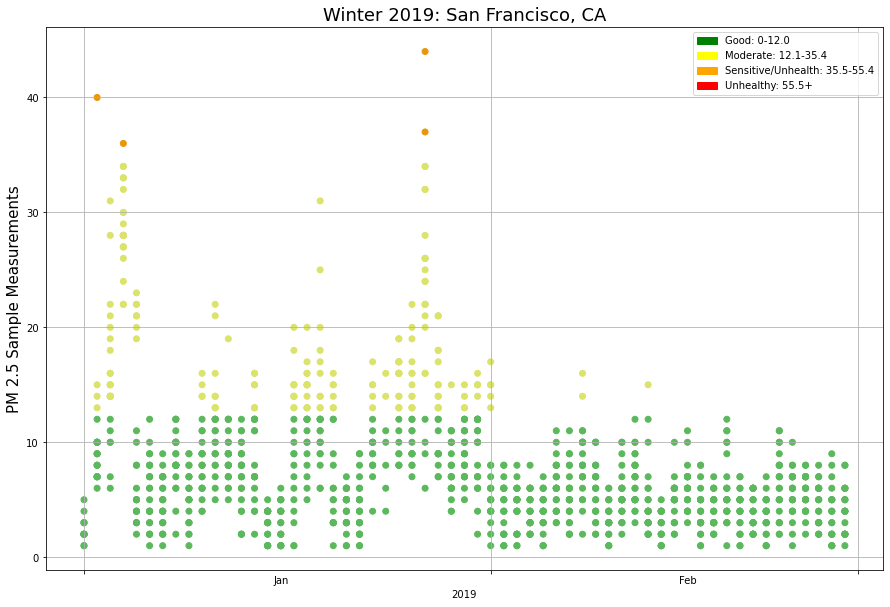

In [181]:
# Assigm date as index of dataframe. Dataframe index has dates
date = plot_df.index.astype('O')

# Data for plt
x = date
y = plot_y_information
c = color_threshold.values


# Plot subplots
fig, ax = plt.subplots(figsize=(15,10))
scatter = ax.scatter(x,y, c=c)

# Set month in xaxis by searching date format
ax.xaxis.set_major_locator(dates.MonthLocator())

# 16 is a slight approximation since months differ in number of days.
ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=16))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%b'))

# loop for custom tickers. Assign marker size and center text
for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment('center')

imid = len(plot_df) // 2
ax.set_xlabel(str(date[imid].year))
ax.set_ylabel('PM 2.5 Sample Measurements', size=15)
ax.set_title('Winter 2019: San Francisco, CA', size=18)
plt.grid(True)

# Labels for legend
green = mpatches.Patch(color='green', label='Good: 0-12.0')
yellow = mpatches.Patch(color='yellow', label='Moderate: 12.1-35.4')
orange = mpatches.Patch(color='orange', label='Sensitive/Unhealth: 35.5-55.4')
red = mpatches.Patch(color='red', label='Unhealthy: 55.5+')
#Call legend
plt.legend(handles = [green,yellow,orange,red])

# Save an image of the chart and print it to the screen
plt.savefig("./Images/SF_winter_pm25_scatter.png")
plt.show()

In [169]:
# Seperate by site_number
winter_ca_sf['site_number'].unique()
# Identify Site Number: 1103. Filter out values affiliated
winter_site_number_5=winter_ca_sf[(winter_ca_sf[['site_number']]==5).all(axis=1)]


In [170]:
winter_site_number_5=winter_site_number_5[['site_number','sample_measurement','time_gmt']].reset_index().set_index('site_number').sort_values(by=['time_gmt'], ascending=True)


In [171]:
# Make a list of site_numbers. Used in for loops to grab specific data by site number & used for new df header.
filtered_ca_sf_box_list = winter_ca_sf.site_number.sort_values().unique().tolist()
filtered_ca_sf_box_list

[5]

#### Begin IQR for Box Plots

In [172]:
# Look through sample measurement list and count the amount of mice in each drug regimen.
# Create an empty list to fill with for loop
measurement_quartile_winter=[]

# Search through filtered_ca_la_box_data with '.loc[site_number, 'sample_measurement' column]' and get the quartile
for i in filtered_ca_sf_box_list:
    location = winter_ca_sf_box.loc[i, 'sample_measurement'].quantile(q=[.25, .5, .75])
    # append results to measurement_quartile list before moving to next value in tumor_regimen_list
    measurement_quartile_winter.append(location)
measurement_quartile_winter

[0.25     4.0
 0.50     6.0
 0.75    10.0
 Name: sample_measurement, dtype: float64]

In [173]:
iqr_all_winter = []

# loop through measurement_quartile range (0-10). Find IQR by selecting one value at a time in the measurement_quartile list. 
for i in range(len(measurement_quartile_winter)):
    iqr = (measurement_quartile_winter[i][0.75])-(measurement_quartile_winter[i][0.25])
    # Append finding to iqr_all list before moving to next value
    iqr_all_winter.append(iqr)
#print(iqr_all_spring)

# Round numbers to 1 number after decimal.
round_iqr_all_winter = [round(num, 2) for num in iqr_all_winter]

In [174]:
# Show list. Verify we have correct amount
assert len(iqr_all_winter) == 1

In [175]:
# Combine both for loop generated list into one.
measurements_iqr_all_winter = [dict(zip(headers_list, round_iqr_all_winter))]
measurements_iqr_all_winter

[{'San Francisco (5)': 6.0}]

#### Begin Box Plots

In [176]:
# Values for plotting
box_values_winter = round_iqr_all_winter
# Sort to determine outliers
values_sorted_winter = sorted(box_values_winter)
print(values_sorted_winter)

[6.0]


In [177]:
# Sample measurement values per site location
winter_site_5_measurements = winter_site_number_5['sample_measurement']

Number of Samples Measured: 1338


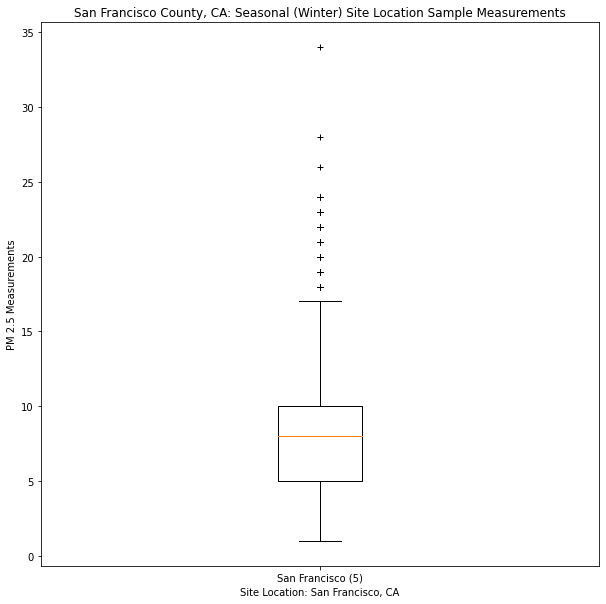

In [182]:
# Generate a box plot of the sample measurement of each site location, annually
fig, ax = plt.subplots(figsize=(10, 10))
pos = np.array(range(len(measurement_plot_info))) + 1
bp = ax.boxplot(measurement_plot_info, sym='k+', showfliers=True)

ax.set_xticklabels(headers_list)
ax.set_xlabel('Site Location: San Francisco, CA')
ax.set_ylabel('PM 2.5 Measurements')
ax.set_title('San Francisco County, CA: Seasonal (Winter) Site Location Sample Measurements')

plt.savefig("./Images/SF_winter_pm25_BoxPlot.png")
print(f'Number of Samples Measured: {len(winter_ca_sf)}')
plt.show()

#### Potential Outliers
Filtering by outlier values and dates may tell us which day/month of the year has larger than normal air pollution measurements. 

In [179]:
# San Francisco, CA (16) Outliers
sf_winter_outliers = bp["fliers"][0].get_data()[1]
sf_winter_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(winter_site_5_measurements)}')
print(f'Total amount of outliers: {len(sf_winter_outliers)}')
print(f'San Francisco Outlier values: {sf_winter_outliers}')

Total amount samples in set: 1338
Total amount of outliers: 76
San Francisco Outlier values: [18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18.
 18. 18. 18. 18. 18. 19. 19. 19. 19. 19. 19. 19. 19. 20. 20. 20. 20. 20.
 20. 20. 20. 20. 20. 20. 20. 20. 20. 21. 21. 21. 21. 21. 21. 21. 21. 21.
 22. 22. 22. 22. 22. 22. 22. 23. 23. 23. 23. 23. 23. 23. 23. 24. 24. 24.
 24. 26. 28. 34.]
